In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [5]:
actions = [
    'forward', 'backward', 'up', 'down', 'right', 'left', ' stop'
]

data = np.concatenate([
    np.load('/home/seojin/ros2_ws/src/robot_arm_v3/robot_arm_v3/dataset/seq_ stop_1725451281.npy'),
    np.load('/home/seojin/ros2_ws/src/robot_arm_v3/robot_arm_v3/dataset/seq_backward_1725451281.npy'),
    np.load('/home/seojin/ros2_ws/src/robot_arm_v3/robot_arm_v3/dataset/seq_down_1725451281.npy'),
    np.load('/home/seojin/ros2_ws/src/robot_arm_v3/robot_arm_v3/dataset/seq_forward_1725451281.npy'),
    np.load('/home/seojin/ros2_ws/src/robot_arm_v3/robot_arm_v3/dataset/seq_left_1725451281.npy'),
    np.load('/home/seojin/ros2_ws/src/robot_arm_v3/robot_arm_v3/dataset/seq_right_1725451281.npy'),
    np.load('/home/seojin/ros2_ws/src/robot_arm_v3/robot_arm_v3/dataset/seq_up_1725451281.npy'),
], axis=0)

data.shape

(12433, 30, 100)

In [6]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(12433, 30, 99)
(12433,)


In [7]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(12433, 7)

In [8]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(11189, 30, 99) (11189, 7)
(1244, 30, 99) (1244, 7)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:7]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 7)                 231       
                                                                 
Total params: 44295 (173.03 KB)
Trainable params: 44295 (173.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200


2024-09-04 21:14:57.563203: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 132925320 exceeds 10% of free system memory.


349/350 [============================>.] - ETA: 0s - loss: 130.6037 - acc: 0.3758
Epoch 1: val_acc improved from -inf to 0.35691, saving model to models/model.h5
350/350 [==============================] - 10s 21ms/step - loss: 130.9469 - acc: 0.3755 - val_loss: 162.6237 - val_acc: 0.3569 - lr: 0.0010
Epoch 2/200
  7/350 [..............................] - ETA: 6s - loss: 177.8224 - acc: 0.2634

/home/seojin/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


348/350 [============================>.] - ETA: 0s - loss: 192.1809 - acc: 0.3567
Epoch 2: val_acc improved from 0.35691 to 0.53698, saving model to models/model.h5
350/350 [==============================] - 7s 21ms/step - loss: 191.3821 - acc: 0.3571 - val_loss: 23.8037 - val_acc: 0.5370 - lr: 0.0010
Epoch 3/200
348/350 [============================>.] - ETA: 0s - loss: 37.7354 - acc: 0.5876
Epoch 3: val_acc did not improve from 0.53698
350/350 [==============================] - 7s 19ms/step - loss: 37.6766 - acc: 0.5880 - val_loss: 41.7412 - val_acc: 0.4622 - lr: 0.0010
Epoch 4/200
350/350 [==============================] - ETA: 0s - loss: 20.6880 - acc: 0.6650
Epoch 4: val_acc improved from 0.53698 to 0.61736, saving model to models/model.h5
350/350 [==============================] - 6s 18ms/step - loss: 20.6880 - acc: 0.6650 - val_loss: 22.6106 - val_acc: 0.6174 - lr: 0.0010
Epoch 5/200
349/350 [============================>.] - ETA: 0s - loss: 17.6303 - acc: 0.7012
Epoch 5: val_ac

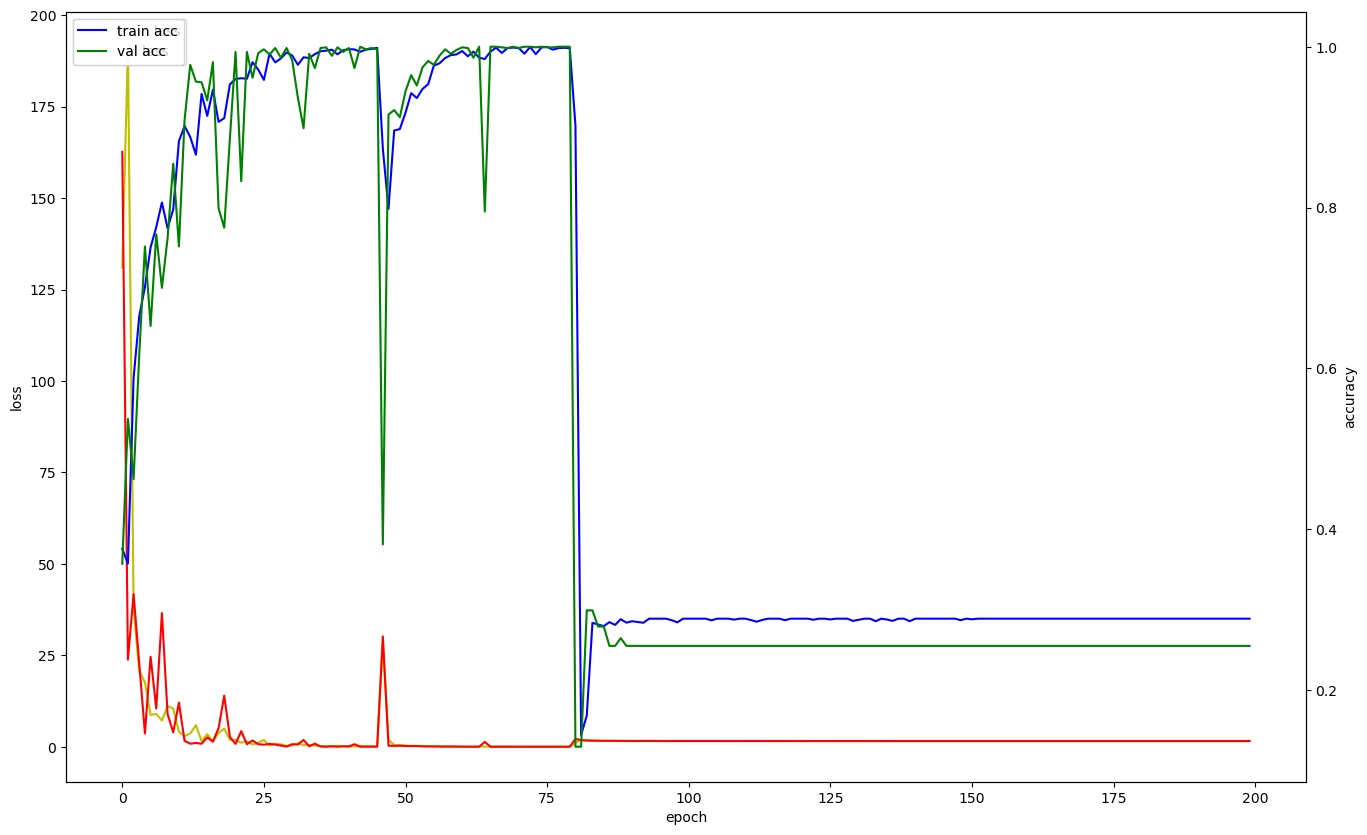

In [11]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [23]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

11/11 [==============================] - 0s 7ms/step


array([[[263,   0],
        [  0,  86]],

       [[268,   0],
        [  0,  81]],

       [[247,   0],
        [  0, 102]],

       [[269,   0],
        [  0,  80]]])